<a href="https://colab.research.google.com/github/AnacletoLAB/grape/blob/main/notebooks/GloVe_to_embed_Cora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using GloVe to compute Cora's node embedding
In the following tutorial we will compute Cora's node embedding using GloVe, both using the high-level pipeline and the model itself.

We start by installing the GraPE library:

```bash
pip install grape -U
```

We assume you have already properly set up TensorFlow on your machine with it running within a GPU or similar hardware accelerator. If you do not have a similar setup available in your system, the GraPE library will warn you before proceeding further because running these models without a GPU will be significantly slower. You can learn more about properly setupping your TensorFlow on GPU [here](https://www.tensorflow.org/install/gpu).

A valid alternative is to run this tutorial on COLAB.

In [1]:
!pip install -q grape -U

     |████████████████████████████████| 53 kB 1.7 MB/s 


Additionally, we install also some other dependencies we will be using during the tutorial.

In [4]:
!pip install -q plot_keras_history seedir silence_tensorflow
!pip install -q tsnecuda==3.0.0+cu110 -f https://tsnecuda.isx.ai/tsnecuda_stable.html --no-dependencies
!pip install -q MulticoreTSNE
!pip install -q faiss

In [5]:
# In order to disable often useless TensorFlow warnings
import silence_tensorflow.auto

## Retrieving Cora
We will now proceed to retrieve the Cora graph, using Ensmallen's automatic graph retrieval. You can learn more about the automatic graph retrieval in [add tutorial reference here].

In [6]:
from ensmallen.datasets.linqs import Cora
from ensmallen.datasets.linqs.parse_linqs import get_words_data

In [7]:
graph, node_features = get_words_data(Cora())

Extracting words features:   0%|          | 0/4141 [00:00<?, ?it/s]

### Taking a look at the graph report

In [8]:
graph

<h2>Cora</h2><p>The undirected graph Cora has 2708 heterogenous nodes and 5278 homogeneous edges.</p><h3>RAM requirements</h3><p>The RAM requirements for the nodes and edges data structures are 399.52KB and 16.26KB respectively.</p><h3>Degree centrality</h3><p>The minimum node degree is 1, the maximum node degree is 168, the mode degree is 2, the mean degree is 3.90 and the node degree median is 3.</p><p>The nodes with highest degree centrality are: 35 (degree 168 and node type Genetic_Algorithms), 6213 (degree 78 and node type Reinforcement_Learning), 1365 (degree 74 and node type Neural_Networks), 3229 (degree 65 and node type Neural_Networks) and 910 (degree 44 and node type Neural_Networks).</p><h3>Node types</h3><p>The graph has 7 node types, of which the 5 most common are Neural_Networks (818 nodes, 30.21%), Probabilistic_Methods (426 nodes, 15.73%), Genetic_Algorithms (418 nodes, 15.44%), Theory (351 nodes, 12.96%) and Case_Based (298 nodes, 11.00%).</p><h4>RAM requirements</h4><p>The RAM requirements for the node types data structure is 136.99KB.</p><h3>Edge types</h3><p>The graph has a single edge type, which is Paper2Paper. Note that this means that all edges have the same edge type, that is, all edges are homogeneous..</p><h4>RAM requirements</h4><p>The RAM requirements for the edge types data structure is 42.61KB.</p>

### Taking a look at the node features
Even though the SkipGram model does not take in consideration the node features, these values are available for Cora so let's take a look.

In [9]:
node_features

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,word_10,word_11,word_12,word_13,word_14,word_15,word_16,word_17,word_18,word_19,word_20,word_21,word_22,word_23,word_24,word_25,word_26,word_27,word_28,word_29,word_30,word_31,word_32,word_33,word_34,word_35,word_36,word_37,word_38,word_39,...,word_1393,word_1394,word_1395,word_1396,word_1397,word_1398,word_1399,word_1400,word_1401,word_1402,word_1403,word_1404,word_1405,word_1406,word_1407,word_1408,word_1409,word_1410,word_1411,word_1412,word_1413,word_1414,word_1415,word_1416,word_1417,word_1418,word_1419,word_1420,word_1421,word_1422,word_1423,word_1424,word_1425,word_1426,word_1427,word_1428,word_1429,word_1430,word_1431,word_1432
31336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1061127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1106406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37879,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1128977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1128978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117328,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,

## Running GloVe from the default pipeline

### First-order random walk based sampling

0epoch [00:00, ?epoch/s]

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7a0c015ad0>,
       dtype=object))

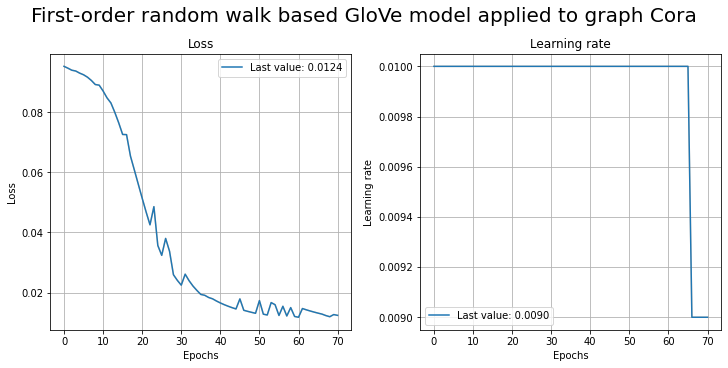

In [10]:
from embiggen.pipelines import compute_node_embedding
from plot_keras_history import plot_history

node_embedding_method_name = "GloVe"

first_order_rw_node_embedding, training_history = compute_node_embedding(
    graph,
    node_embedding_method_name=node_embedding_method_name,
)

plot_history(
    training_history,
    title="First-order random walk based {} model applied to graph {}".format(
        node_embedding_method_name,
        graph.get_name()
    )
)

Let's take a look at the obtained node embedding:

In [11]:
first_order_rw_node_embedding

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
31336,0.254068,0.233917,-0.352596,-0.350436,-0.158030,0.303531,-0.248570,0.112863,0.263872,0.189468,0.223249,-0.100408,-0.240979,-0.184389,0.268439,-0.168427,-0.193159,0.037138,0.195321,-0.119739,0.058051,-0.258440,-0.170961,0.211627,0.277178,-0.340669,0.278036,0.162085,0.266078,-0.239297,0.327048,-0.285375,-0.059401,0.117144,0.355145,-0.221728,0.295167,0.011761,0.291977,-0.083888,...,0.147740,-0.331461,-0.265258,-0.263127,-0.184565,0.260699,0.218589,0.129498,-0.327789,0.312033,0.100471,0.098824,-0.271761,0.305652,0.278444,0.297276,-0.165350,-0.249701,-0.227002,0.187157,0.302880,0.242517,-0.290551,0.210122,0.304081,0.104494,0.100088,-0.307165,0.332825,-0.208749,0.223356,-0.285194,0.057508,0.292833,0.233212,0.147279,0.247976,0.287321,0.283299,0.166431
1061127,0.400425,0.387883,-0.285369,-0.386031,0.129995,0.308376,0.064184,-0.279103,0.333974,-0.246927,0.321003,0.321924,-0.411954,-0.363819,0.190692,-0.380819,-0.331384,0.235834,0.345078,-0.094852,-0.316902,0.110084,0.170215,-0.184025,-0.210675,-0.333703,0.359135,-0.124031,-0.342714,-0.357106,0.302645,0.217558,-0.357219,0.379935,0.398259,-0.336783,-0.283143,-0.263566,-0.080541,-0.323022,...,0.340387,-0.336941,-0.407874,-0.308841,-0.321599,0.199144,-0.132273,0.182724,-0.352791,0.386195,0.345714,0.306881,-0.312362,0.029293,0.352271,0.330063,-0.357423,-0.351559,-0.210941,0.347478,0.383881,0.294964,-0.396806,0.384850,0.217324,0.385382,0.378089,-0.408505,0.290362,-0.324413,0.323622,-0.304485,-0.297581,0.373287,-0.208679,0.165223,0.338346,0.374154,-0.245870,-0.317796
1106406,0.326055,-0.096745,-0.277648,-0.364844,0.279830,0.110597,-0.277980,-0.248857,0.086790,-0.252320,-0.262667,0.279728,-0.307800,0.189024,0.274530,-0.283618,-0.240604,0.348783,0.330431,-0.364278,-0.294394,0.154342,-0.343084,0.256629,0.341548,-0.279735,0.368781,0.344517,0.335083,-0.358031,-0.182776,-0.280867,0.273665,0.310183,0.358371,-0.024798,0.260766,-0.284193,0.328061,-0.297235,...,0.223620,-0.267356,-0.232162,-0.288297,-0.362215,0.359117,0.264728,0.179685,-0.345198,0.303469,0.353085,0.361093,0.254723,0.284571,0.268483,0.296132,-0.345605,0.230695,0.256843,-0.272932,0.275434,0.315329,-0.343074,-0.213211,0.346901,0.308873,0.323896,-0.280355,-0.003685,-0.288689,0.324761,-0.314920,-0.240102,0.285260,0.269437,-0.302427,-0.273676,-0.157564,0.341624,-0.301412
13195,0.272849,-0.000895,-0.296415,-0.376761,0.193573,0.037766,-0.309674,-0.161796,0.108684,-0.231380,-0.275839,0.208208,-0.223603,0.171017,0.207610,-0.270554,-0.335924,0.296996,0.277107,-0.377671,-0.303594,-0.034496,-0.262276,0.277252,0.300780,-0.289558,0.374158,0.294731,0.294430,-0.251898,-0.090080,-0.295403,0.214307,0.291292,0.329654,-0.244161,0.274070,-0.296961,0.349544,-0.283843,...,0.248892,-0.205352,-0.204742,-0.187407,-0.294652,0.297899,0.349897,0.228205,-0.282208,0.268483,0.340927,0.312938,0.198483,0.328719,0.301076,0.327501,-0.299518,0.207635,0.167795,-0.263039,0.294411,0.337038,-0.341100,-0.157002,0.263945,0.201908,0.218163,-0.280756,0.036802,-0.326716,0.243472,-0.223537,-0.122027,0.317249,0.342243,-0.201774,-0.205699,-0.111994,0.266342,-0.287472
37879,0.070492,0.012207,-0.186255,-0.249542,-0.149857,0.253804,-0.252590,0.032265,-0.034943,0.148122,0.333148,0.052019,-0.032652,0.088965,0.102385,-0.007948,-0.097681,0.265313,0.120602,-0.123039,-0.267497,-0.231967,-0.269220,0.346621,0.137455,-0.440203,0.179358,0.228704,-0.033269,-0.328162,-0.034839,-0.151549,0.204286,0.237965,0.313859,-0.340067,0.387527,-0.284179,0.040368,-0.150718,...,0.324536,-0.072648,0.266146,0.225633,-0.348674,-0.019853,0.077652,0.247802,-0.103515,0.201350,0.279699,0.150767,-0.084246,0.192736,0.061183,0.064409,0.042571,-0.197425,0.098811,0.137702,0.332599,0.084101,-0.262828,-0.071318,0.332238,0.031805,-0.108718,-0.227802,0.004437,-0.080093,0.384202,0.042507,0.066

Note that the `compute_node_embedding` method also automatically handles the caching of the computed node embedding, and it is all made available in the node embeddings directory:

In [12]:
from seedir import seedir

seedir("node_embeddings")

node_embeddings/
├─GloVe/
│ └─Cora/
│   ├─2ee9e857b4142fc31aa4ed459e1fff3161d3c4b9a94fa866d58d14a0af24f5a9_training_history.csv.xz.metadata
│   ├─2ee9e857b4142fc31aa4ed459e1fff3161d3c4b9a94fa866d58d14a0af24f5a9_embedding.pkl.gz.metadata
│   ├─bdcc1fed4c1cff6c32dafb7dd3c1557df607758e31ab38d809b4888d6688b56c_embedding.pkl.gz.metadata
│   ├─bdcc1fed4c1cff6c32dafb7dd3c1557df607758e31ab38d809b4888d6688b56c_embedding.pkl.gz
│   ├─2ee9e857b4142fc31aa4ed459e1fff3161d3c4b9a94fa866d58d14a0af24f5a9_training_history.csv.xz
│   ├─bdcc1fed4c1cff6c32dafb7dd3c1557df607758e31ab38d809b4888d6688b56c_training_history.csv.xz.metadata
│   ├─2ee9e857b4142fc31aa4ed459e1fff3161d3c4b9a94fa866d58d14a0af24f5a9_embedding.pkl.gz
│   └─bdcc1fed4c1cff6c32dafb7dd3c1557df607758e31ab38d809b4888d6688b56c_training_history.csv.xz
└─SkipGram/
  └─Cora/
    ├─117780dcf98d0d48057a7b7410c361d2290a0eb5138b8627a2f591a508292f28_embedding.pkl.gz
    ├─500c14c68f79a799d6d5f5f5c879244783d5f4e07c5ea3db99ec620a982a2611_training_histor

### Second-order random walk based sampling
In some cases, one may want to use the Node2Vec sampling, which is a second-order random walk based sampling.

0epoch [00:00, ?epoch/s]

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f79f8e5ea10>,
       dtype=object))

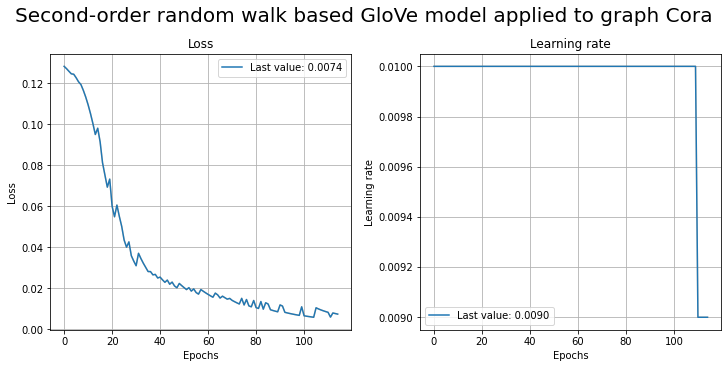

In [14]:
from embiggen.pipelines import compute_node_embedding
from plot_keras_history import plot_history

node_embedding_method_name = "GloVe"

second_order_rw_node_embedding, training_history = compute_node_embedding(
    graph,
    node_embedding_method_name=node_embedding_method_name,
    # Let's increase the probability of explore the local neighbourhood
    return_weight=2.0,
    explore_weight=0.1
)

plot_history(
    training_history,
    title="Second-order random walk based {} model applied to graph {}".format(
        node_embedding_method_name,
        graph.get_name()
    )
)

Let's take a look at this new embedding

In [15]:
second_order_rw_node_embedding

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
31336,-0.219435,-0.180079,0.363802,-0.177472,0.046897,-0.095270,0.076620,0.274115,-0.041393,0.258123,-0.178015,0.371107,-0.273189,0.167186,-0.190074,-0.058133,-0.306865,-0.222573,0.120423,0.176683,-0.304774,-0.227224,0.262632,0.013187,-0.281033,-0.459838,-0.345617,-0.551442,-0.260004,-0.072897,-0.215793,0.151237,-0.330841,0.299392,-0.254822,-0.367812,-0.289186,-0.089381,0.321179,0.205966,...,0.348442,0.423524,0.335875,-0.020831,0.283615,0.132545,0.192204,-0.065652,-0.254961,0.244400,0.420349,-0.384187,0.321045,-0.184295,-0.358848,-0.097347,0.000382,-0.419836,0.107901,0.239559,0.015031,-0.179113,-0.353444,0.135334,-0.352521,-0.192231,-0.257793,-0.089434,-0.114321,-0.161965,-0.380231,0.057324,-0.431747,0.270941,-0.205757,-0.039775,-0.616205,0.166036,-0.104646,0.022888
1061127,0.317734,0.040862,-0.181960,-0.407312,-0.323315,0.388794,0.340957,-0.244542,0.382004,0.374566,-0.396680,0.475985,-0.322940,-0.152180,-0.355628,-0.372095,-0.082353,-0.246497,-0.112016,-0.253169,-0.390872,0.409412,0.388529,-0.447862,0.403253,-0.510551,0.112450,-0.416084,-0.323845,-0.381343,-0.357171,0.298773,-0.432353,-0.356325,0.298910,-0.453657,0.412349,0.378516,0.430137,-0.433606,...,0.401435,0.418451,0.474098,-0.427282,0.345808,0.428580,-0.016625,0.413974,0.320610,-0.220227,-0.348112,-0.414508,-0.421325,-0.490595,0.280067,0.448726,-0.141137,-0.323970,0.182750,0.182468,0.323506,-0.405274,-0.316783,-0.395533,-0.461289,0.354308,-0.462065,0.386571,-0.354929,-0.337671,-0.367453,-0.440965,-0.361915,0.368510,-0.004642,0.270063,-0.419927,-0.311834,-0.235139,0.261068
1106406,-0.325505,0.300962,0.353398,-0.470815,-0.234369,0.377327,-0.298672,0.013496,-0.066070,0.401588,0.235518,0.167208,-0.239457,-0.340270,0.281850,-0.233468,-0.123995,0.340440,-0.248348,-0.370163,0.079649,-0.495098,0.063952,-0.405076,0.182351,-0.439119,-0.059757,-0.274218,-0.099622,0.361930,0.302639,-0.345836,0.254046,0.333612,0.272812,-0.366100,-0.113767,0.362801,-0.086259,-0.196221,...,-0.163144,0.373786,0.311756,-0.343223,0.303156,0.361943,-0.264340,0.004349,0.231892,0.280833,0.208951,-0.430763,0.174737,0.321717,0.263263,0.355809,-0.297048,-0.376264,-0.386388,0.277678,0.082238,-0.280651,-0.254922,-0.348480,-0.373442,0.368618,0.064936,0.362248,0.075524,-0.231820,-0.431691,-0.299440,-0.283203,0.317722,0.032766,-0.190781,-0.230770,-0.259555,0.083716,-0.288839
13195,-0.233963,0.338666,0.344715,-0.380059,-0.339342,0.310146,-0.335612,-0.062789,0.037554,0.331828,0.145287,-0.023704,-0.124467,-0.171545,0.284944,-0.275635,-0.182065,0.226395,-0.313006,-0.375622,-0.119684,0.020775,0.031508,-0.379607,0.162817,-0.349661,0.009579,-0.276802,-0.021855,0.352095,0.353538,-0.329008,0.149512,0.351251,0.008994,-0.293117,-0.170820,0.257513,-0.005047,-0.182024,...,-0.181245,0.308476,0.353567,-0.318541,0.316178,0.670114,-0.263321,-0.021658,0.256951,0.177819,0.164295,-0.353217,0.222777,0.314756,0.072466,0.320449,-0.290221,-0.359792,-0.333810,0.236743,-0.258964,-0.234878,-0.163668,-0.388221,-0.378030,0.359812,0.115189,0.263871,-0.048058,-0.192568,-0.277555,-0.198705,-0.283807,0.297829,-0.226581,-0.220723,0.024105,-0.271570,0.096082,-0.308478
37879,-0.207586,0.325677,0.369426,-0.364901,-0.304804,0.126222,-0.191924,0.424145,0.401849,0.242816,0.232917,-0.310336,0.319932,0.218700,-0.096446,0.294015,0.334563,0.300393,-0.378443,-0.305651,-0.210778,-0.081677,-0.389180,-0.336713,-0.230147,-0.388190,-0.388635,0.223707,-0.407163,0.323944,-0.069459,-0.275449,-0.239070,0.444085,-0.210761,-0.206231,-0.115927,0.080184,0.126292,0.333428,...,-0.048442,0.425009,0.479296,-0.346605,0.032662,0.319610,-0.356065,-0.356205,0.272514,-0.263832,-0.214856,-0.423603,0.261552,0.323563,-0.406866,0.293377,-0.205497,-0.370693,-0.105873,0.311330,0.119365,-0.210111,0.270690,-0.408332,-0.359275,0.344772,0.101234,-0.019507,-0.

We can see that in the cache directory are now present two node embeddings.

In [16]:
from seedir import seedir

seedir("node_embeddings")

node_embeddings/
├─GloVe/
│ └─Cora/
│   ├─2ee9e857b4142fc31aa4ed459e1fff3161d3c4b9a94fa866d58d14a0af24f5a9_training_history.csv.xz.metadata
│   ├─a071f93daa81a39bb8b2e2d4fcc305e0179b893feda1eac1e0a63ad3ec703383_embedding.pkl.gz
│   ├─2ee9e857b4142fc31aa4ed459e1fff3161d3c4b9a94fa866d58d14a0af24f5a9_embedding.pkl.gz.metadata
│   ├─bdcc1fed4c1cff6c32dafb7dd3c1557df607758e31ab38d809b4888d6688b56c_embedding.pkl.gz.metadata
│   ├─bdcc1fed4c1cff6c32dafb7dd3c1557df607758e31ab38d809b4888d6688b56c_embedding.pkl.gz
│   ├─a071f93daa81a39bb8b2e2d4fcc305e0179b893feda1eac1e0a63ad3ec703383_training_history.csv.xz
│   ├─2ee9e857b4142fc31aa4ed459e1fff3161d3c4b9a94fa866d58d14a0af24f5a9_training_history.csv.xz
│   ├─a071f93daa81a39bb8b2e2d4fcc305e0179b893feda1eac1e0a63ad3ec703383_embedding.pkl.gz.metadata
│   ├─bdcc1fed4c1cff6c32dafb7dd3c1557df607758e31ab38d809b4888d6688b56c_training_history.csv.xz.metadata
│   ├─2ee9e857b4142fc31aa4ed459e1fff3161d3c4b9a94fa866d58d14a0af24f5a9_embedding.pkl.gz
│   ├─bdcc1

## Using directly the model
Instead of using the high level pipeline, it is surely possible also to use the GloVe model directly. Note that using directly GloVe there won't be applied automatically the distribution strategy across different GPUs, if any, no caching mechanism will be used and no checks will be executed validating the health of your TensorFlow installation (whether GPU drivers are available etc...). 

In [18]:
from embiggen import GraphGloVe

All of the embedding models have the relative documentation, that you can always read by using the help command:

In [19]:
help(GraphGloVe)

Help on class GraphGloVe in module embiggen.embedders.graph_glove:

class GraphGloVe(embiggen.embedders.glove.GloVe)
 |  GraphGloVe(graph: Graph, embedding_size: int = 100, embedding: Union[numpy.ndarray, pandas.core.frame.DataFrame] = None, extra_features: Union[numpy.ndarray, pandas.core.frame.DataFrame] = None, optimizer: Union[str, keras.optimizer_v2.optimizer_v2.OptimizerV2] = None, alpha: float = 0.75, directed: bool = False, walk_length: int = 128, iterations: int = 16, window_size: int = 4, return_weight: float = 1.0, explore_weight: float = 1.0, change_node_type_weight: float = 1.0, change_edge_type_weight: float = 1.0, max_neighbours: int = None, support_mirrored_strategy: bool = False, random_state: int = 42, dense_node_mapping: Dict[int, int] = None, use_gradient_centralization: bool = True)
 |  
 |  GloVe model for graph and words embedding.
 |  
 |  The GloVe model for graoh embedding receives two words and is asked to
 |  predict its cooccurrence probability.
 |  
 |  Me

We need to sort the graph nodes according to the decreasing node degree in order to exploit the Zipfian sampling, which guaranties a better approximation of the Softmax.

In [20]:
model = GraphGloVe(
    graph
)

In [21]:
history = model.fit()

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f79fe5b2d90>,
       dtype=object))

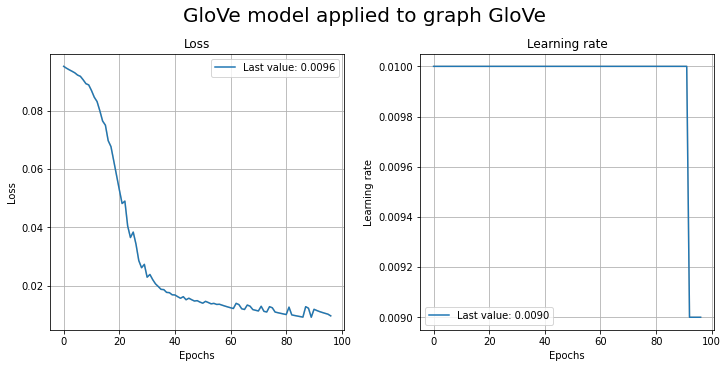

In [22]:
plot_history(
    history,
    title="GloVe model applied to graph {}".format(
        node_embedding_method_name,
        graph.get_name()
    )
)

In [23]:
node_embedding = model.get_embedding_dataframe()

In [24]:
node_embedding

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
31336,0.349439,0.288941,-0.391931,-0.283667,0.207727,-0.013330,0.288794,0.248933,-0.005272,-0.299182,-0.108940,-0.088632,0.177125,-0.074825,-0.005475,0.333751,0.283691,-0.122210,0.343233,-0.149504,0.298892,0.143902,0.274710,0.237001,0.011503,-0.336959,0.211749,0.146773,0.375565,0.206590,-0.208097,-0.173088,-0.211626,0.198696,-0.339170,0.379063,-0.190400,-0.043679,-0.165463,0.052584,...,-0.303832,0.198267,0.003586,-0.279372,0.296807,-0.266102,-0.155445,-0.229454,0.300982,0.207027,-0.312174,0.339009,-0.286344,-0.040232,0.242005,-0.139333,0.400256,-0.161075,0.181312,-0.165644,0.166982,-0.265778,0.337075,0.102055,-0.283979,0.299601,-0.278745,-0.282479,0.293187,-0.218726,0.281946,-0.013532,-0.085756,0.107000,-0.031467,0.261375,-0.300283,-0.292284,0.285941,-0.145183
1061127,0.414913,0.334885,-0.400993,-0.433907,0.366691,-0.410077,0.393996,0.097153,0.432350,-0.058779,0.305618,-0.344507,0.311003,0.408685,-0.399699,0.387859,0.432683,-0.347393,0.351446,-0.320648,0.382661,0.265830,0.315995,-0.366973,0.028171,-0.231587,-0.336973,-0.318461,0.357201,0.271989,-0.134551,0.225224,-0.020624,-0.317911,-0.371852,0.390527,-0.338010,-0.399505,0.071215,0.267017,...,-0.356597,-0.281876,0.218970,0.153762,0.332459,-0.329919,0.347369,-0.394360,0.391304,0.348504,-0.375916,0.390210,-0.416113,-0.405463,-0.277571,-0.444083,0.378278,-0.260750,-0.299452,-0.286442,-0.358076,-0.379169,0.389508,0.391078,-0.354624,-0.315548,-0.369687,-0.077591,-0.203551,-0.355730,0.289831,0.368286,0.382425,0.390368,-0.340746,0.301583,-0.317484,-0.394696,0.402778,-0.313886
1106406,0.337959,0.296028,-0.321954,-0.367137,-0.201237,-0.328846,0.365336,-0.113967,0.288889,-0.365328,0.274292,-0.275844,-0.224724,0.316218,-0.287591,0.292127,0.280634,0.225413,0.365364,0.245878,0.346479,-0.195173,0.337896,0.357376,-0.307065,-0.307137,0.407775,0.224018,0.316013,-0.311490,-0.304940,-0.265309,-0.335794,0.163072,-0.290903,0.322915,0.143554,-0.210313,-0.309570,0.280764,...,-0.308155,-0.191635,0.355547,-0.254140,-0.170242,0.201603,0.342864,-0.371587,0.288228,0.322052,-0.295698,0.308791,-0.315815,0.053294,-0.027922,-0.368926,0.353102,-0.271860,-0.244096,0.278858,-0.312474,-0.279840,0.291646,0.304625,-0.339972,0.335940,-0.331834,-0.294454,0.305068,-0.323329,0.325826,-0.214689,0.303558,0.311093,-0.229105,0.258270,-0.327450,-0.254183,0.317963,0.238323
13195,0.346281,0.342293,-0.301571,-0.381196,-0.198112,-0.322219,0.352361,-0.040735,0.292663,-0.306608,0.188499,-0.206837,-0.213309,0.235994,-0.275432,0.281809,0.323061,0.238454,0.345821,0.260981,0.360103,-0.091275,0.111385,0.151605,-0.287544,-0.307870,0.204881,0.086892,0.342150,-0.341173,-0.299713,-0.289228,-0.332956,0.020953,-0.300590,0.364668,-0.009776,-0.183253,-0.306674,0.220384,...,-0.202911,-0.162087,0.343614,-0.272595,-0.192711,0.109319,0.233438,-0.306766,0.282621,0.333268,-0.263740,0.336395,-0.288024,-0.113531,0.148038,-0.339544,0.349838,-0.169551,-0.302734,0.158138,-0.233960,-0.242188,0.286736,0.261672,-0.287644,0.340994,-0.290430,-0.297192,0.275856,-0.390505,0.233171,-0.125166,0.280395,0.384533,-0.179495,0.255109,-0.262341,-0.278587,0.336160,0.184867
37879,0.243194,0.329977,-0.297537,-0.236883,0.174632,-0.096849,0.096952,0.069999,-0.207280,-0.207694,-0.206866,0.126485,-0.089472,-0.030002,-0.069841,-0.225267,0.123279,0.025890,0.362251,-0.154767,0.226376,-0.001548,0.283749,-0.191897,-0.270438,-0.253447,0.341579,0.207489,0.391435,-0.362065,-0.371601,-0.151234,-0.106205,-0.158276,-0.165141,0.163127,-0.324199,0.091163,-0.092685,0.283903,...,-0.295466,0.022907,-0.124783,-0.337762,-0.004506,-0.125379,0.095413,-0.440182,0.221197,-0.074885,-0.346258,0.328304,-0.332492,-0.163701,0.288594,-0.319919,0.369670,-0.289364,-0.182096,-0.027456,-0.036183,-0.239042,0.252292,0.301226,-0.245649,0.266205,-0.157130,-0.318905,0.311173,-0.4

## Graph visualization
Let's now visualize the two node embeddings. We can use the graph visualization tool available from the Embiggen module.

In [25]:
from embiggen.visualizations import GraphVisualization

We create the visualizer object.

In [26]:
visualizer = GraphVisualization(graph, node_embedding_method=node_embedding_method_name)

And we embedd the node embedding further into a 2D embedding using TSNE (by default), and since we have installed [tsnecude](https://github.com/CannyLab/tsne-cuda) at the beginning of this notebook, the library will automatically use it as it is one of the best TSNE implementations we know of.

In [27]:
visualizer.fit_transform_nodes(first_order_rw_node_embedding)

(<Figure size 1400x1400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f79fc16c110>)

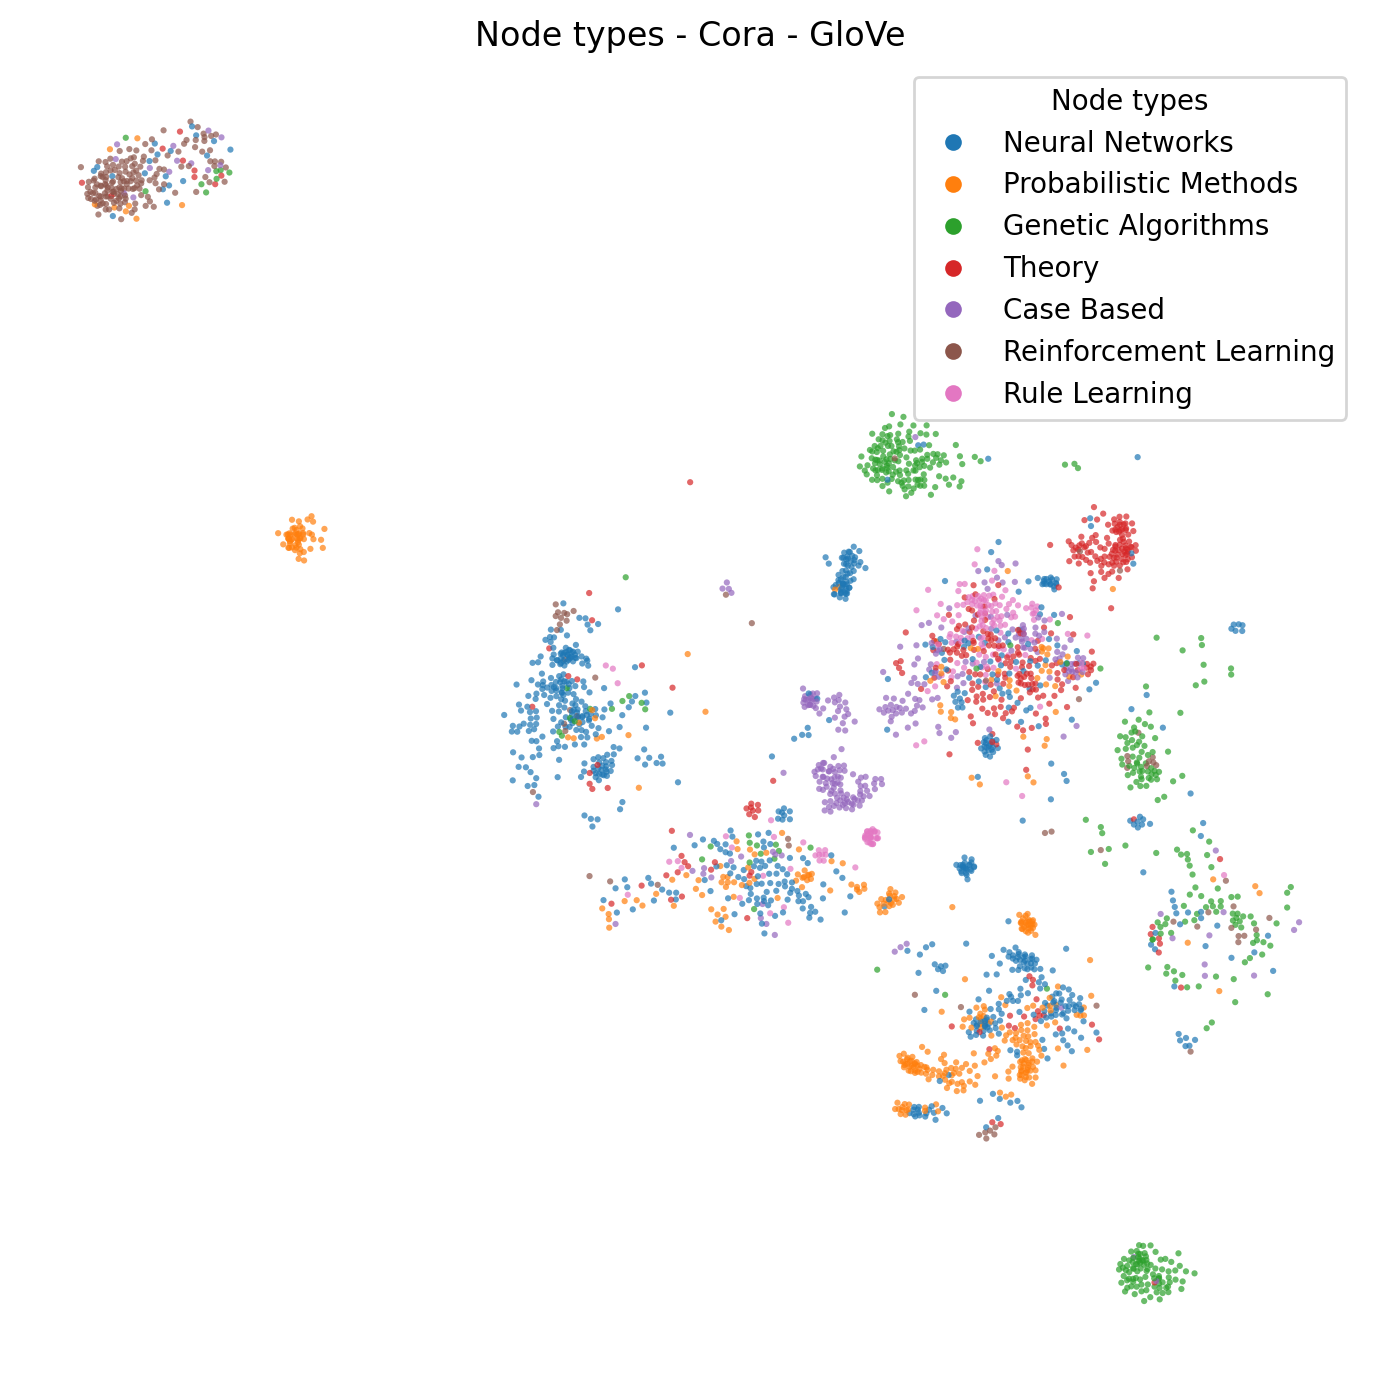

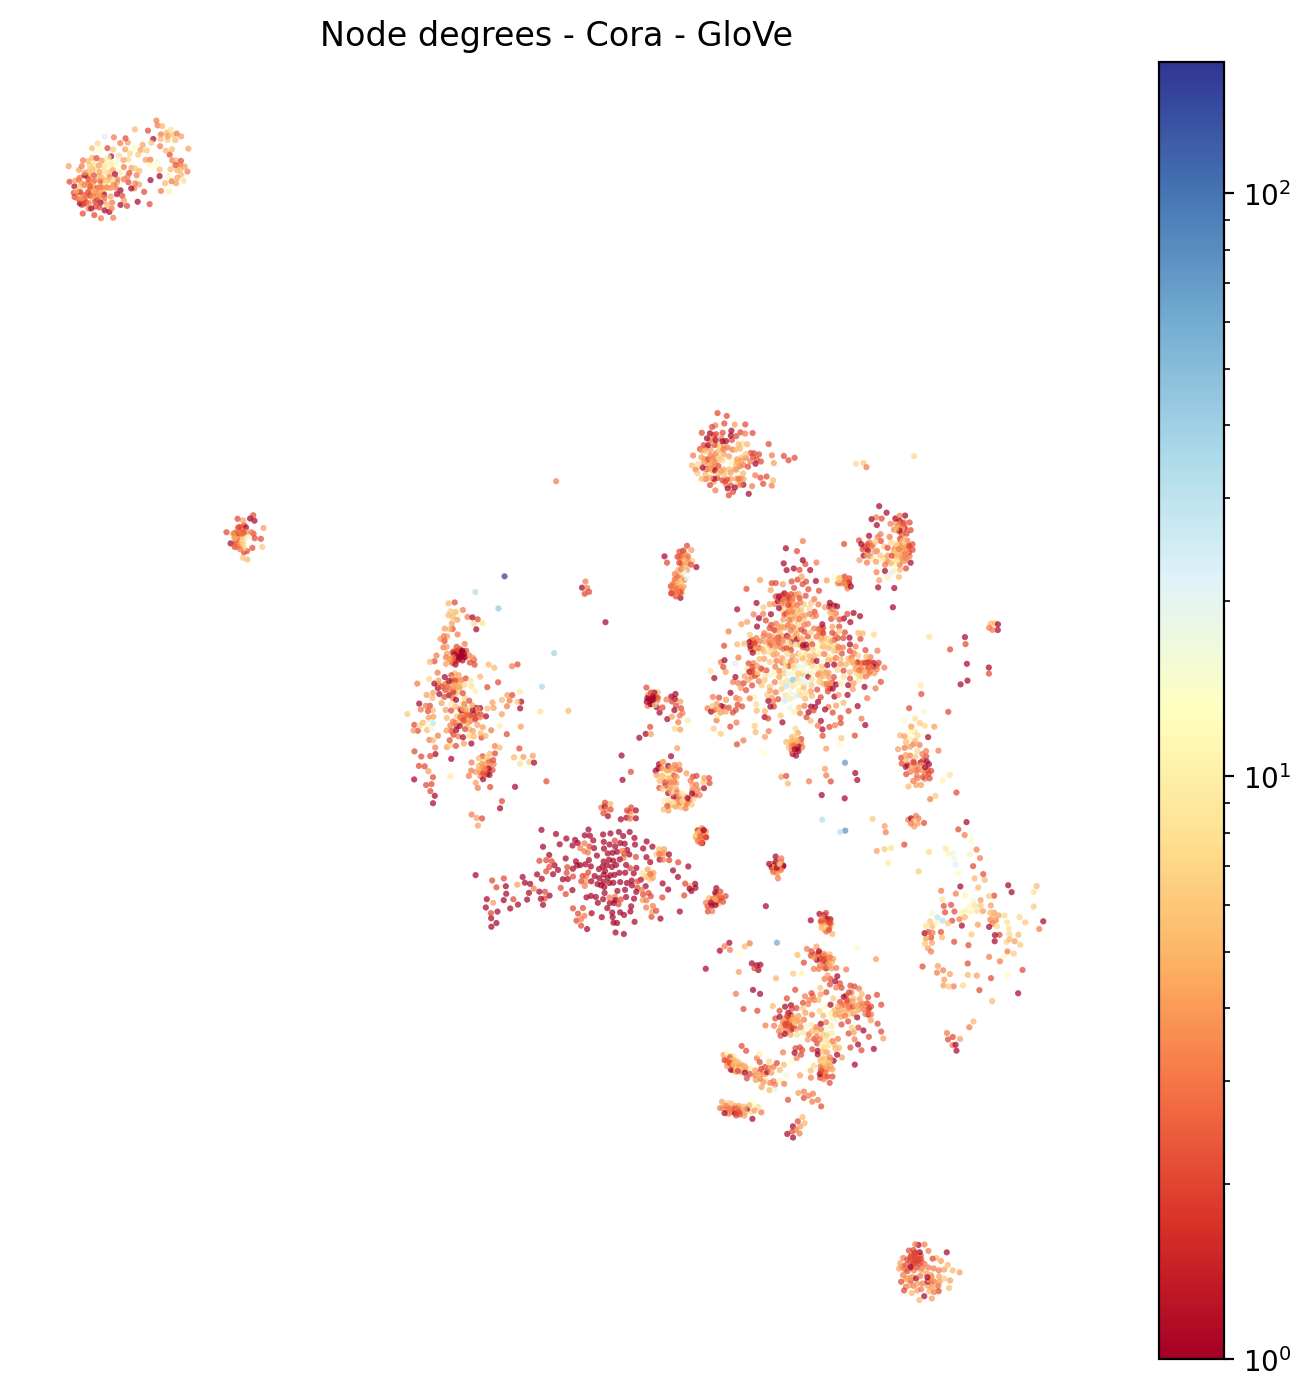

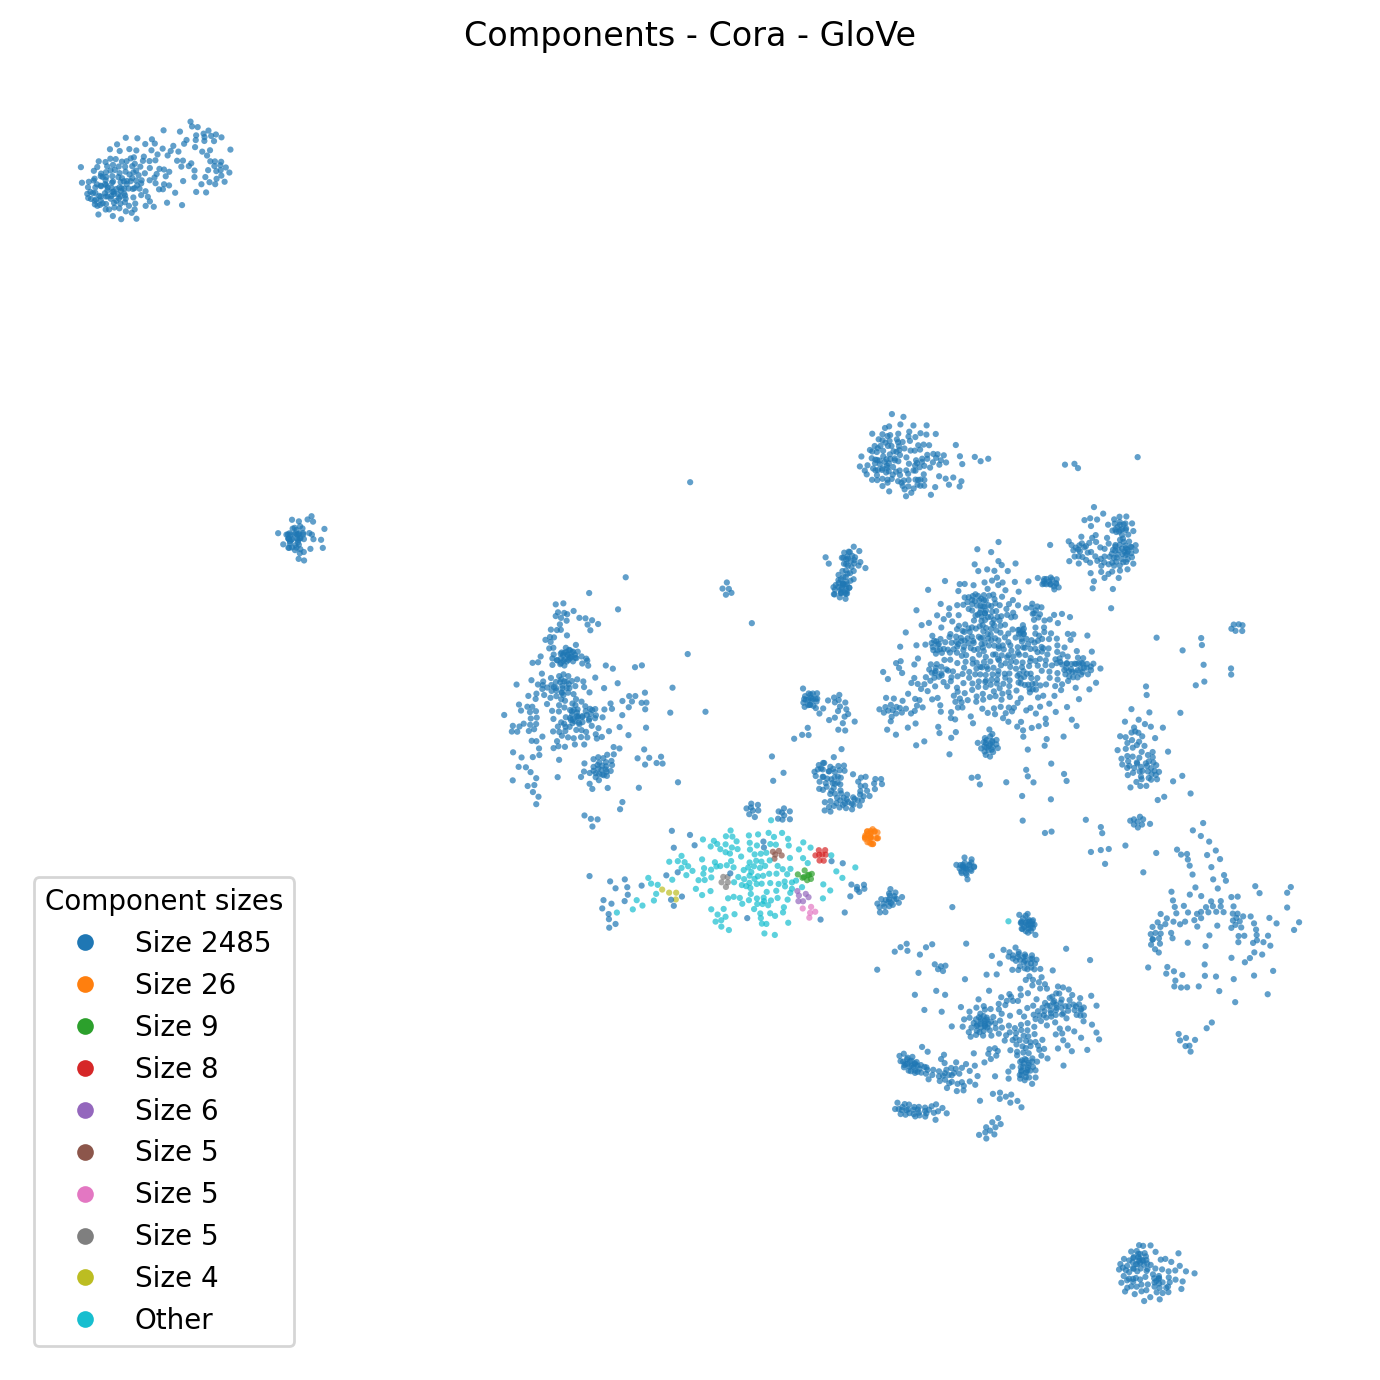

In [28]:
visualizer.plot_node_types()
visualizer.plot_node_degrees()
visualizer.plot_connected_components()

In [29]:
visualizer.fit_transform_nodes(second_order_rw_node_embedding)

(<Figure size 1400x1400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a0c1a73d0>)

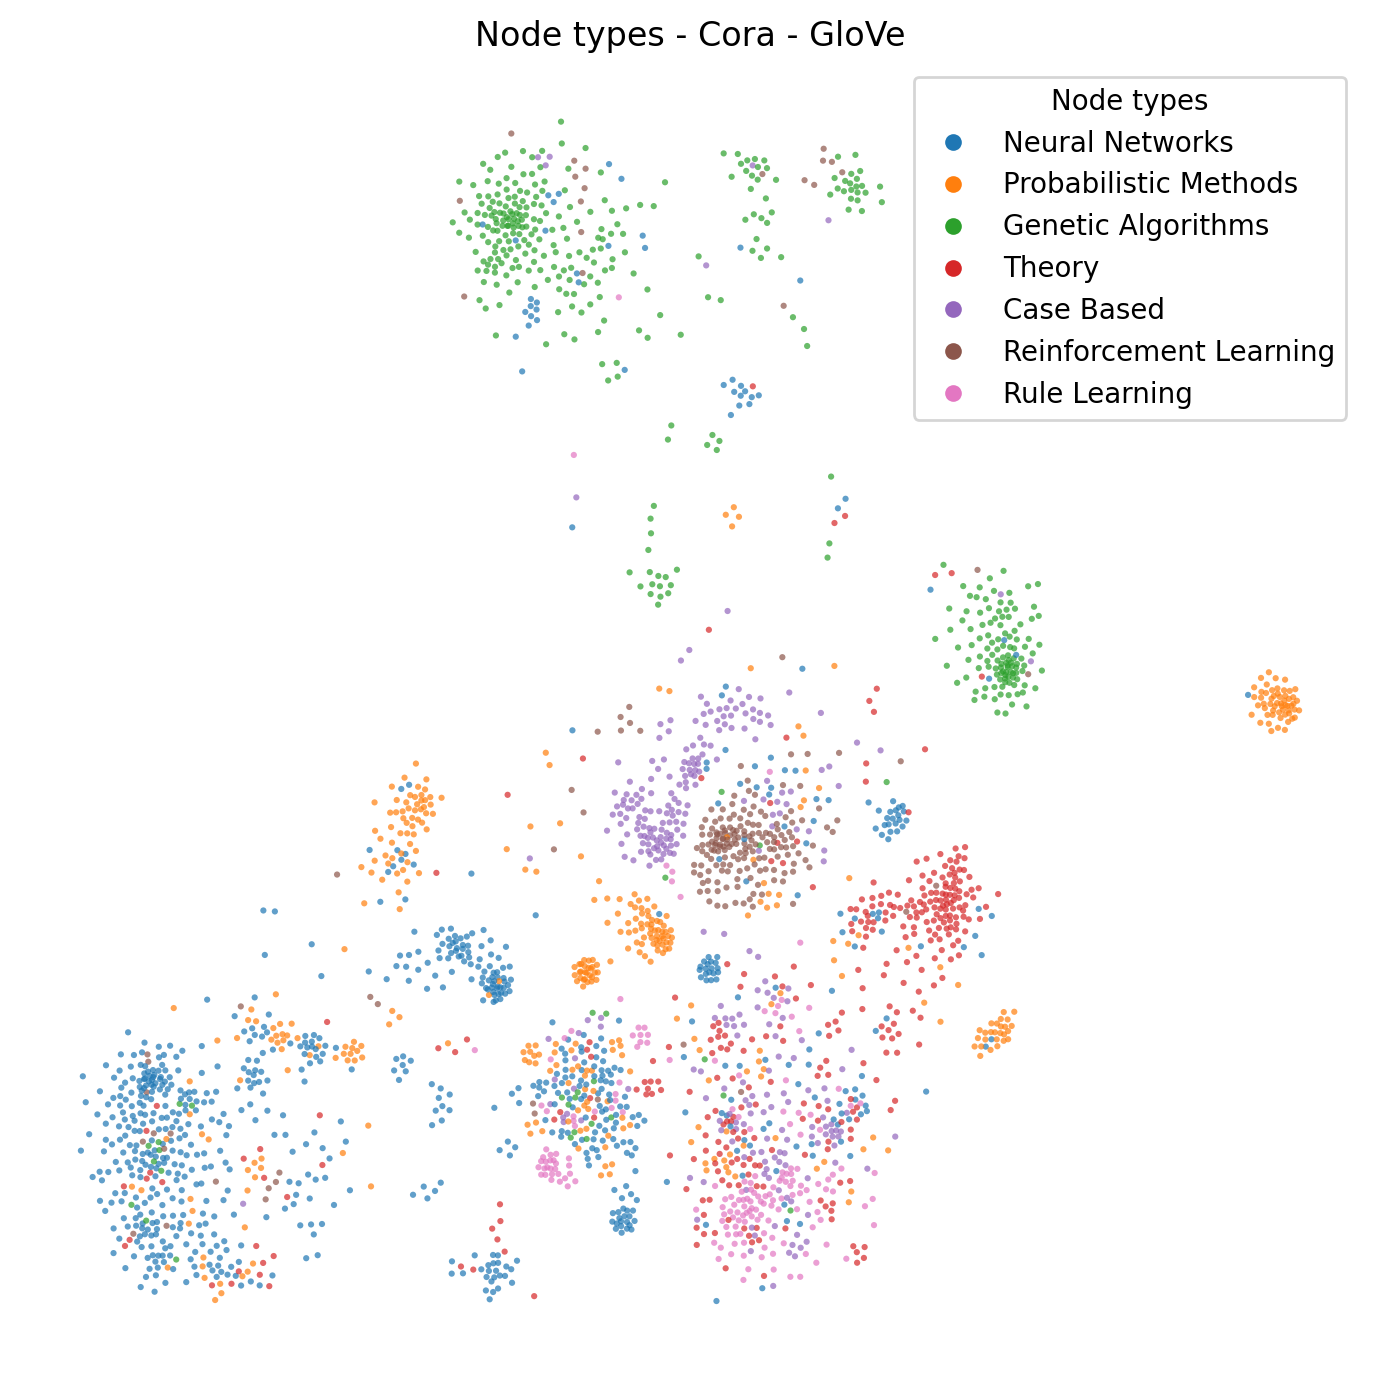

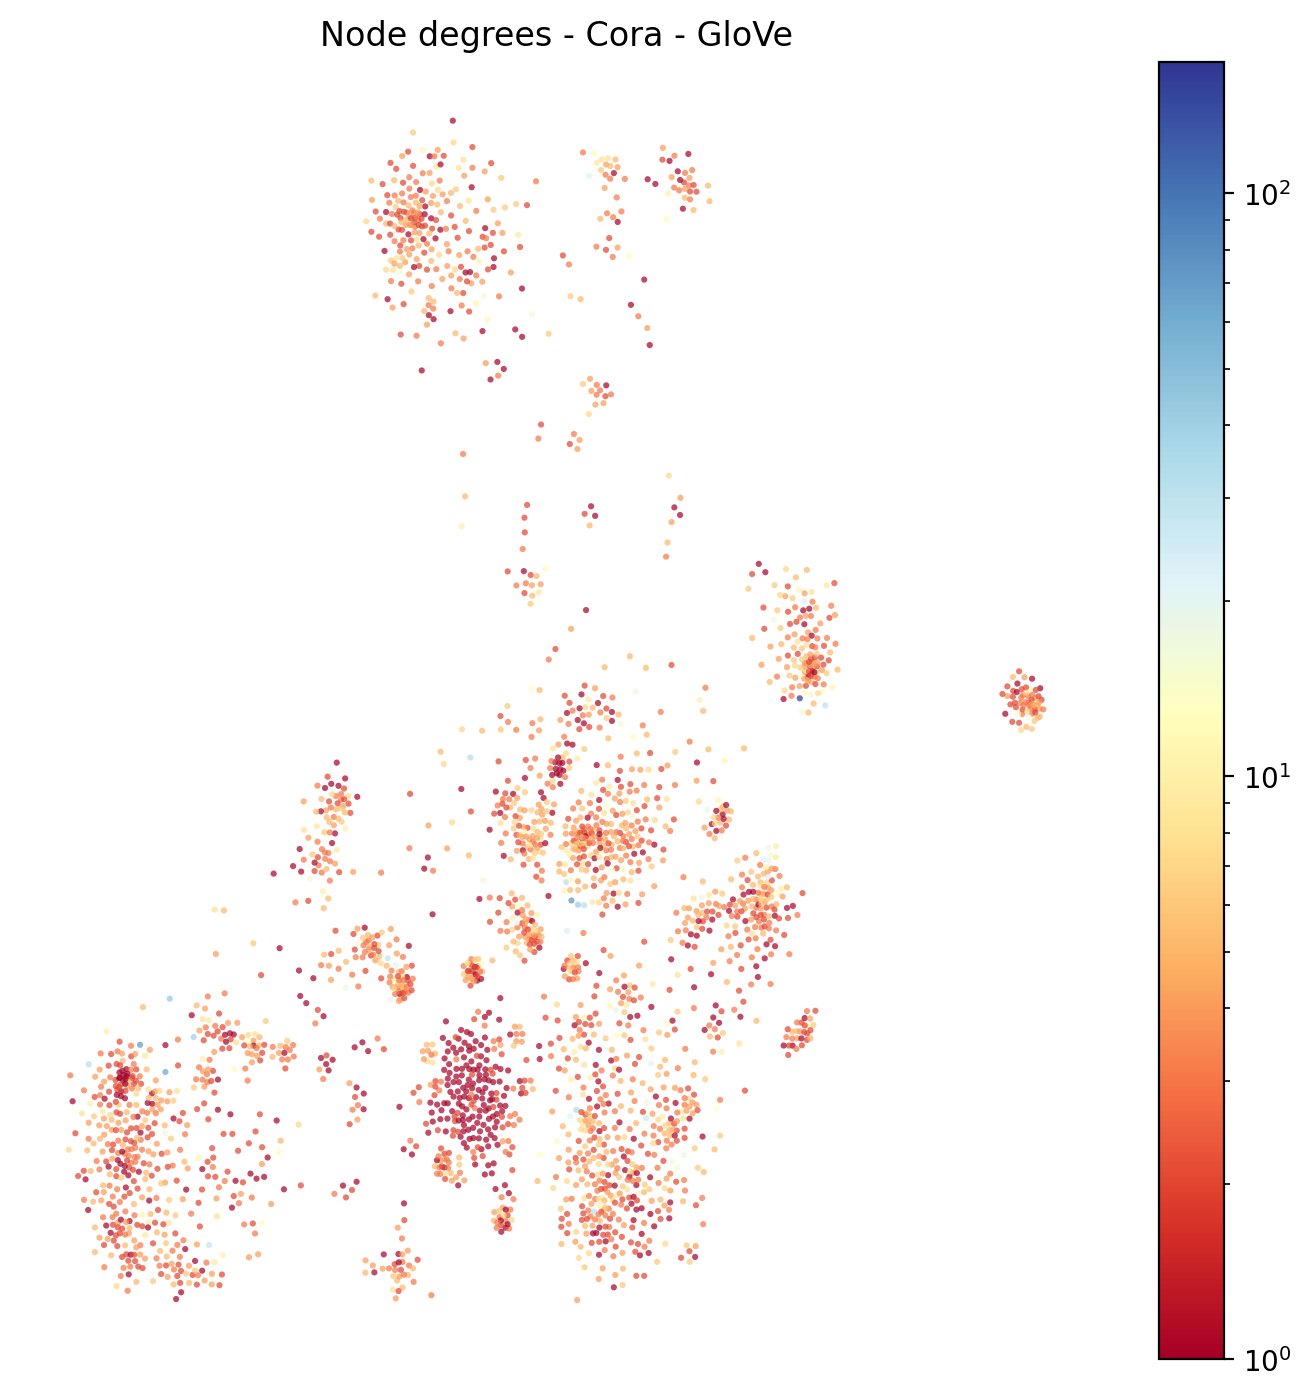

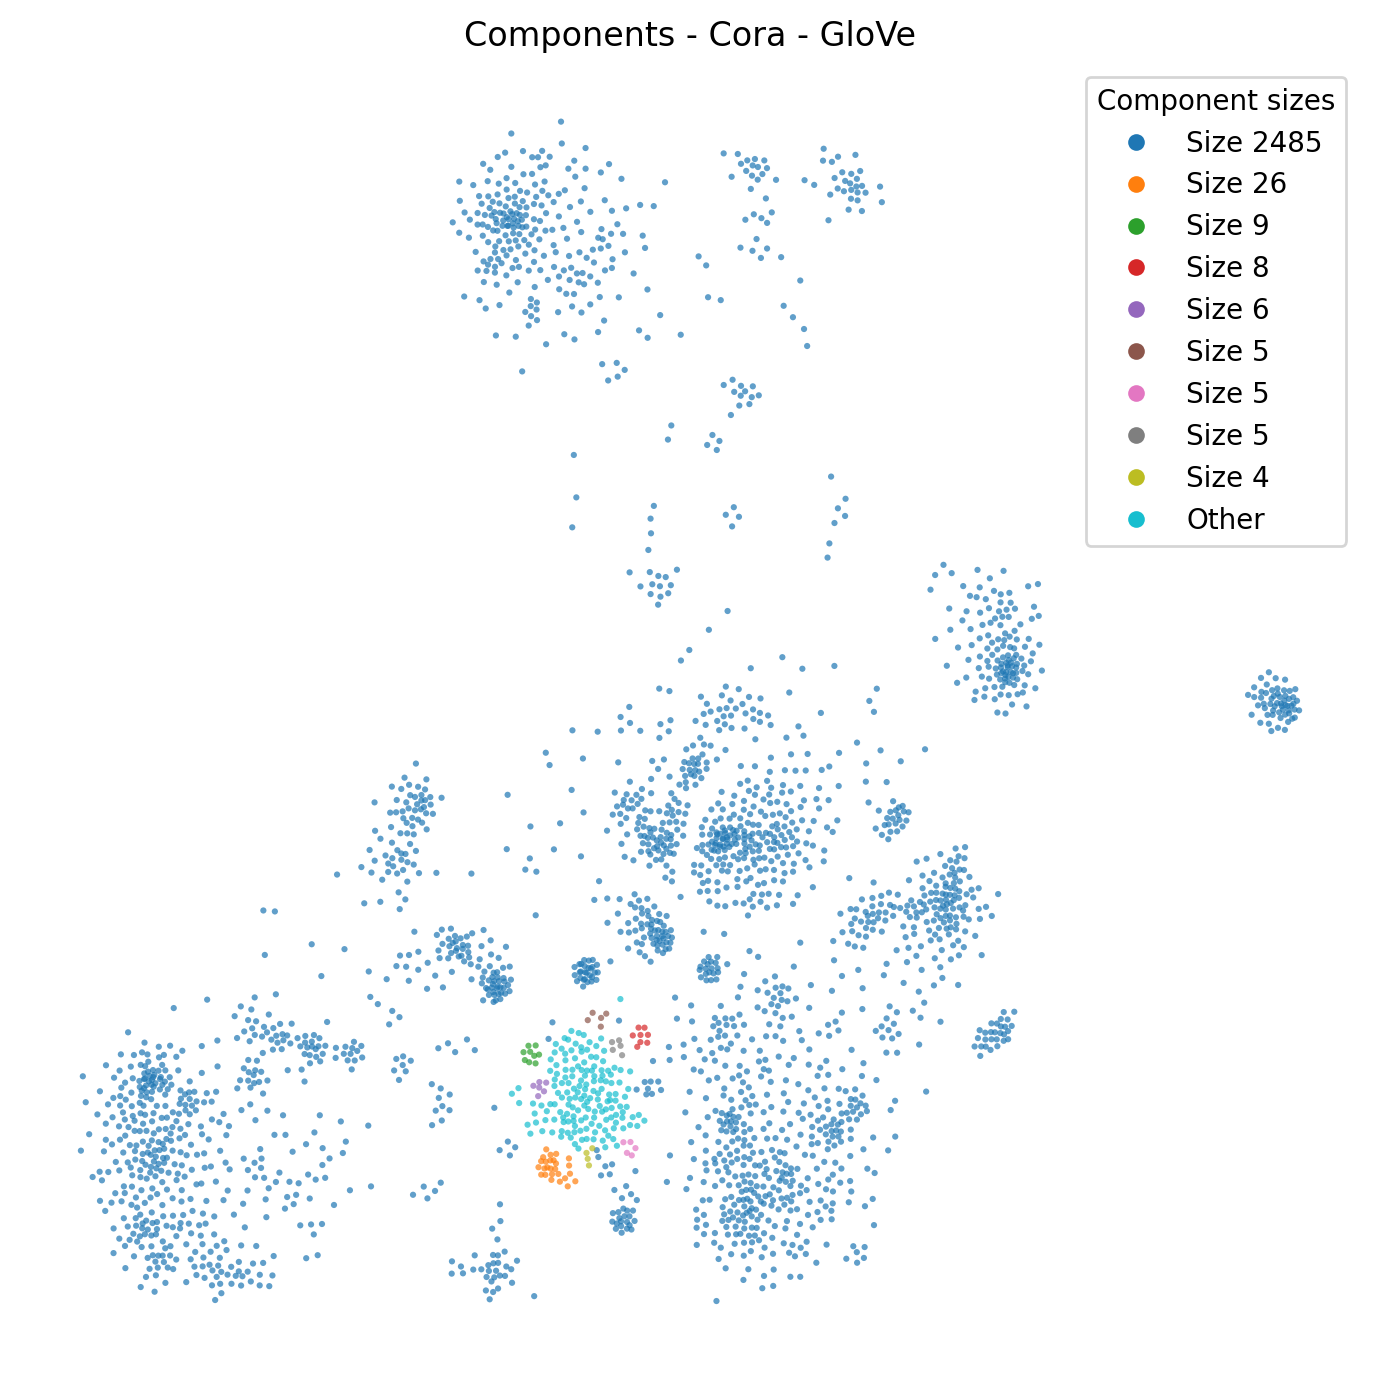

In [30]:
visualizer.plot_node_types()
visualizer.plot_node_degrees()
visualizer.plot_connected_components()

### Visualizing the node features
Using the same visualization tool, we can also visualize the node features. 

Note that cudatsne only supports for now L2 distance, and generally cosine distance works better, so here we use MulticoreTSNE.

In [33]:
visualizer = GraphVisualization(
    graph,
    node_embedding_method="Node labels",
    decomposition_kwargs=dict(
        metric="cosine"
    )
)
visualizer.fit_transform_nodes(node_features)

(<Figure size 1400x1400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f79f8f71690>)

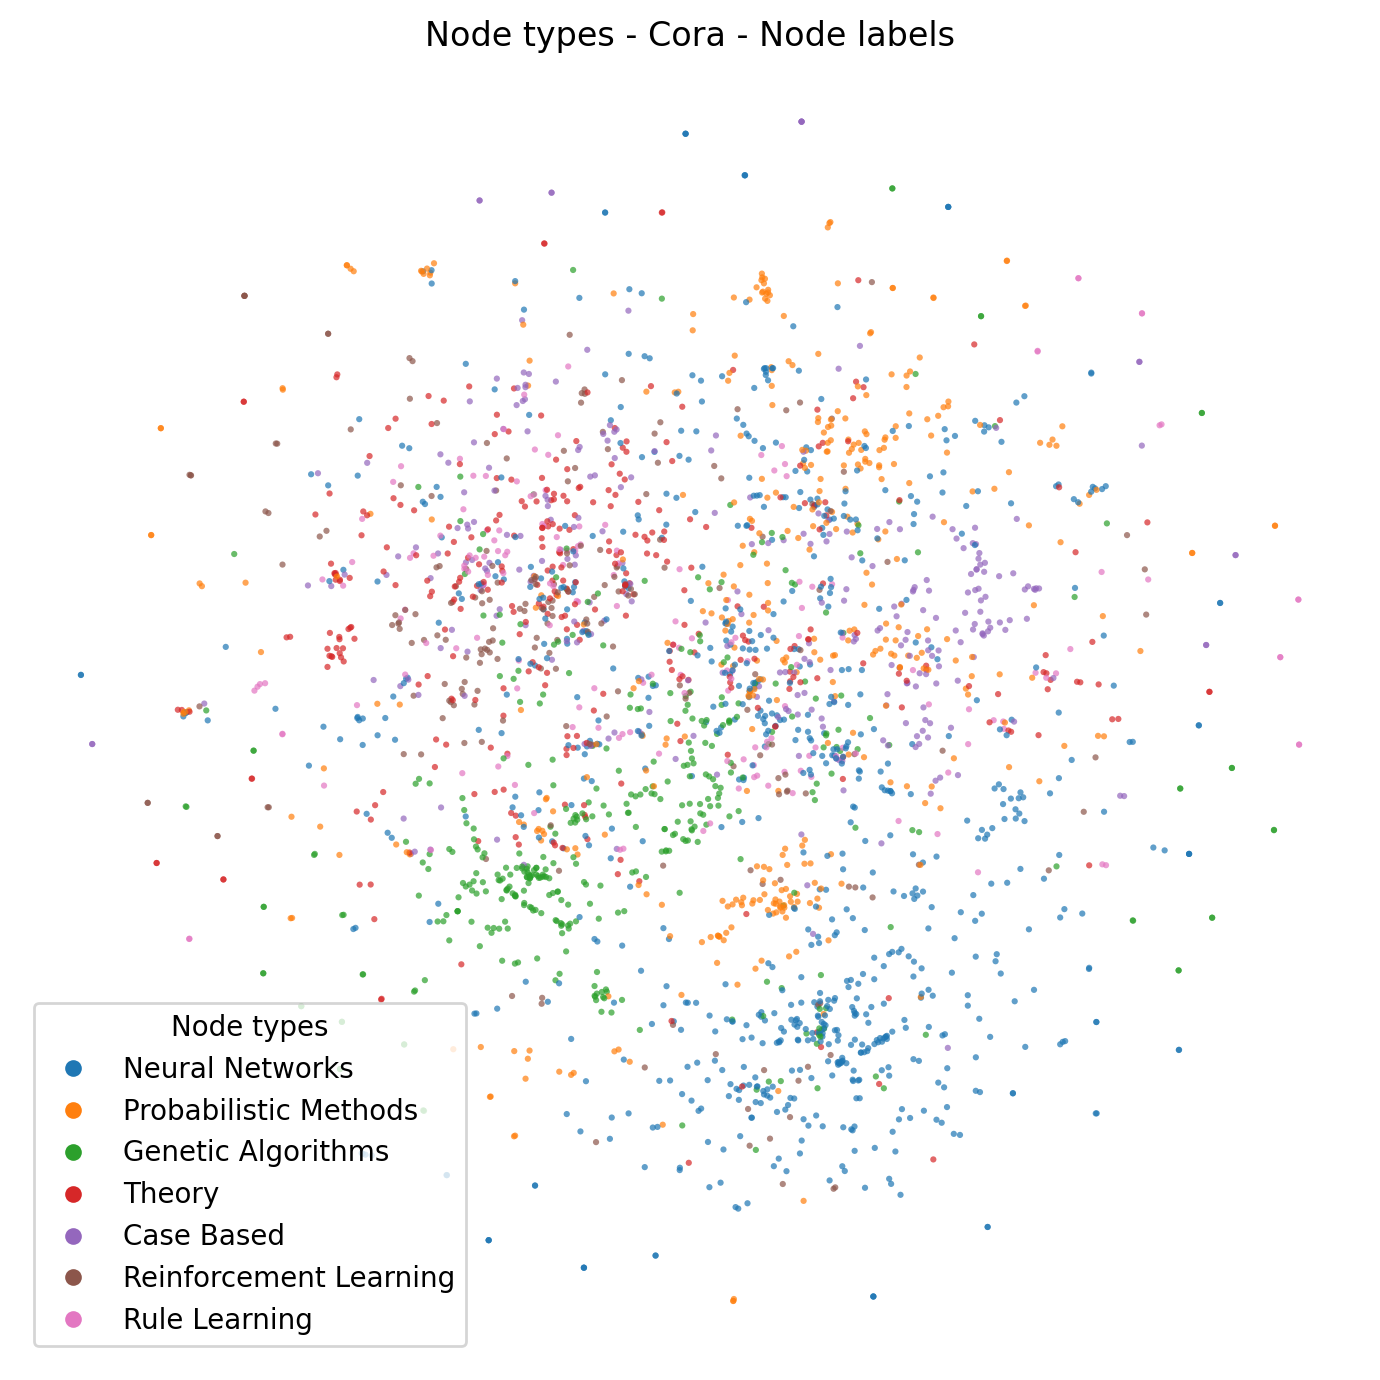

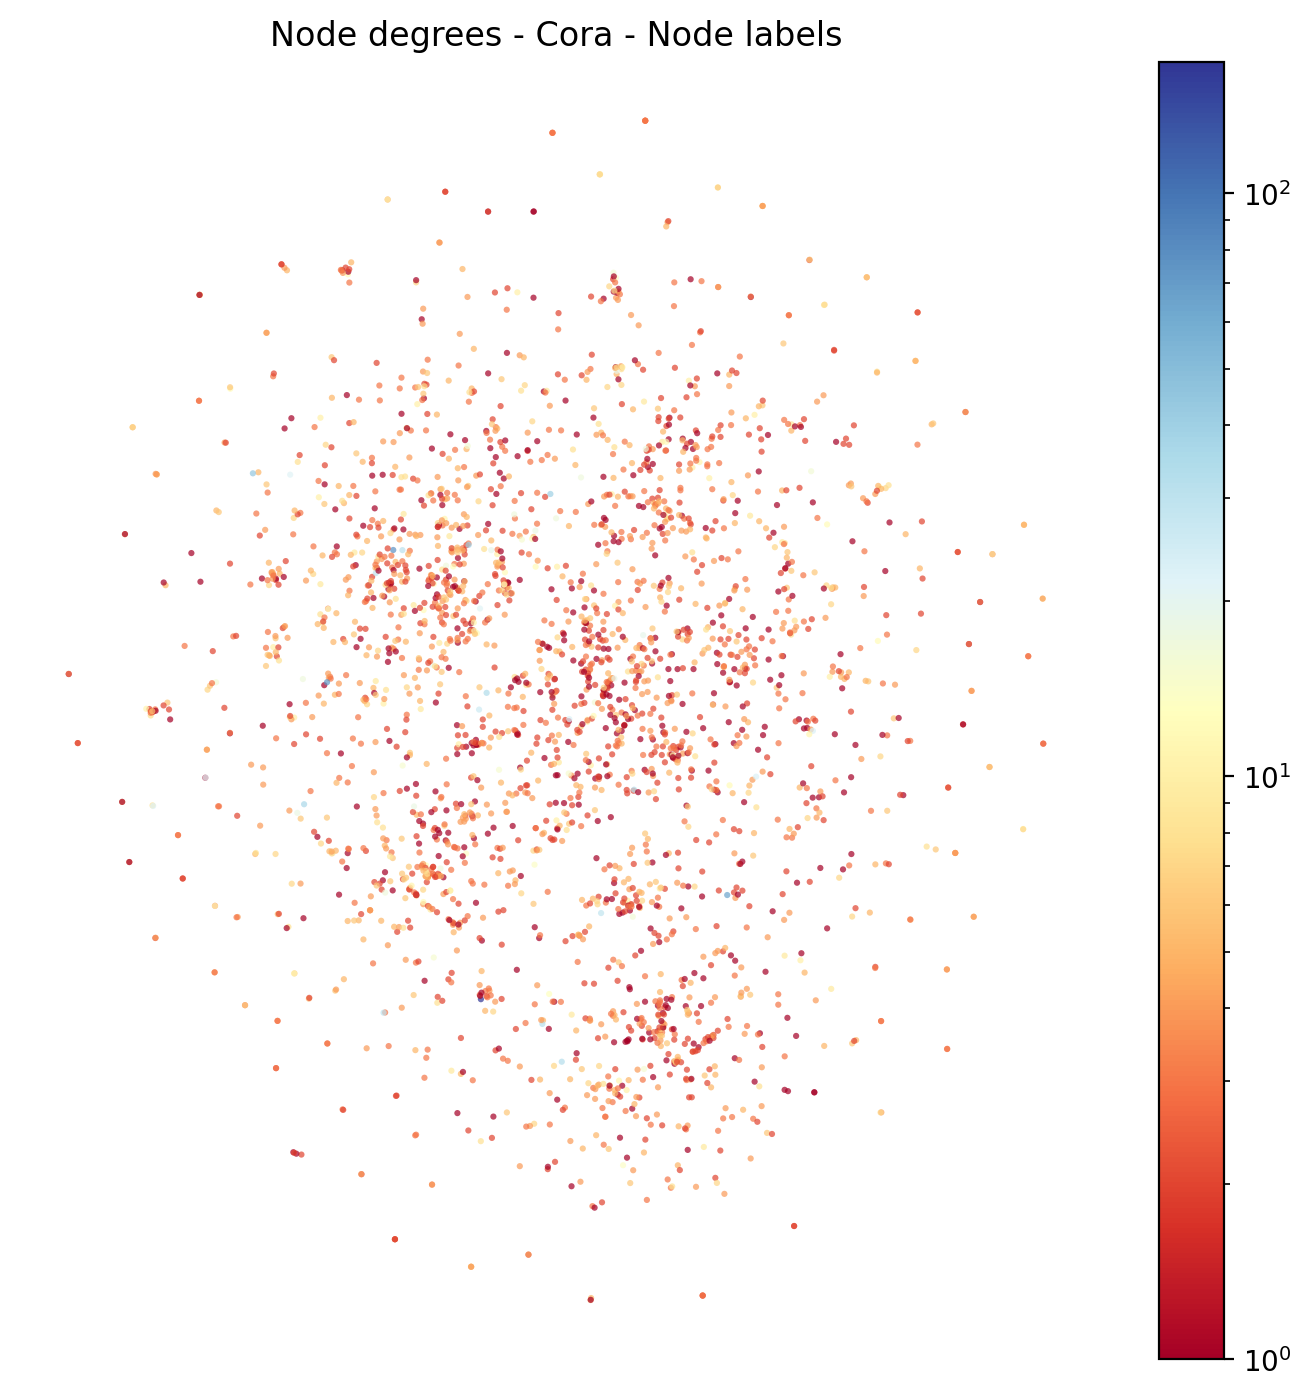

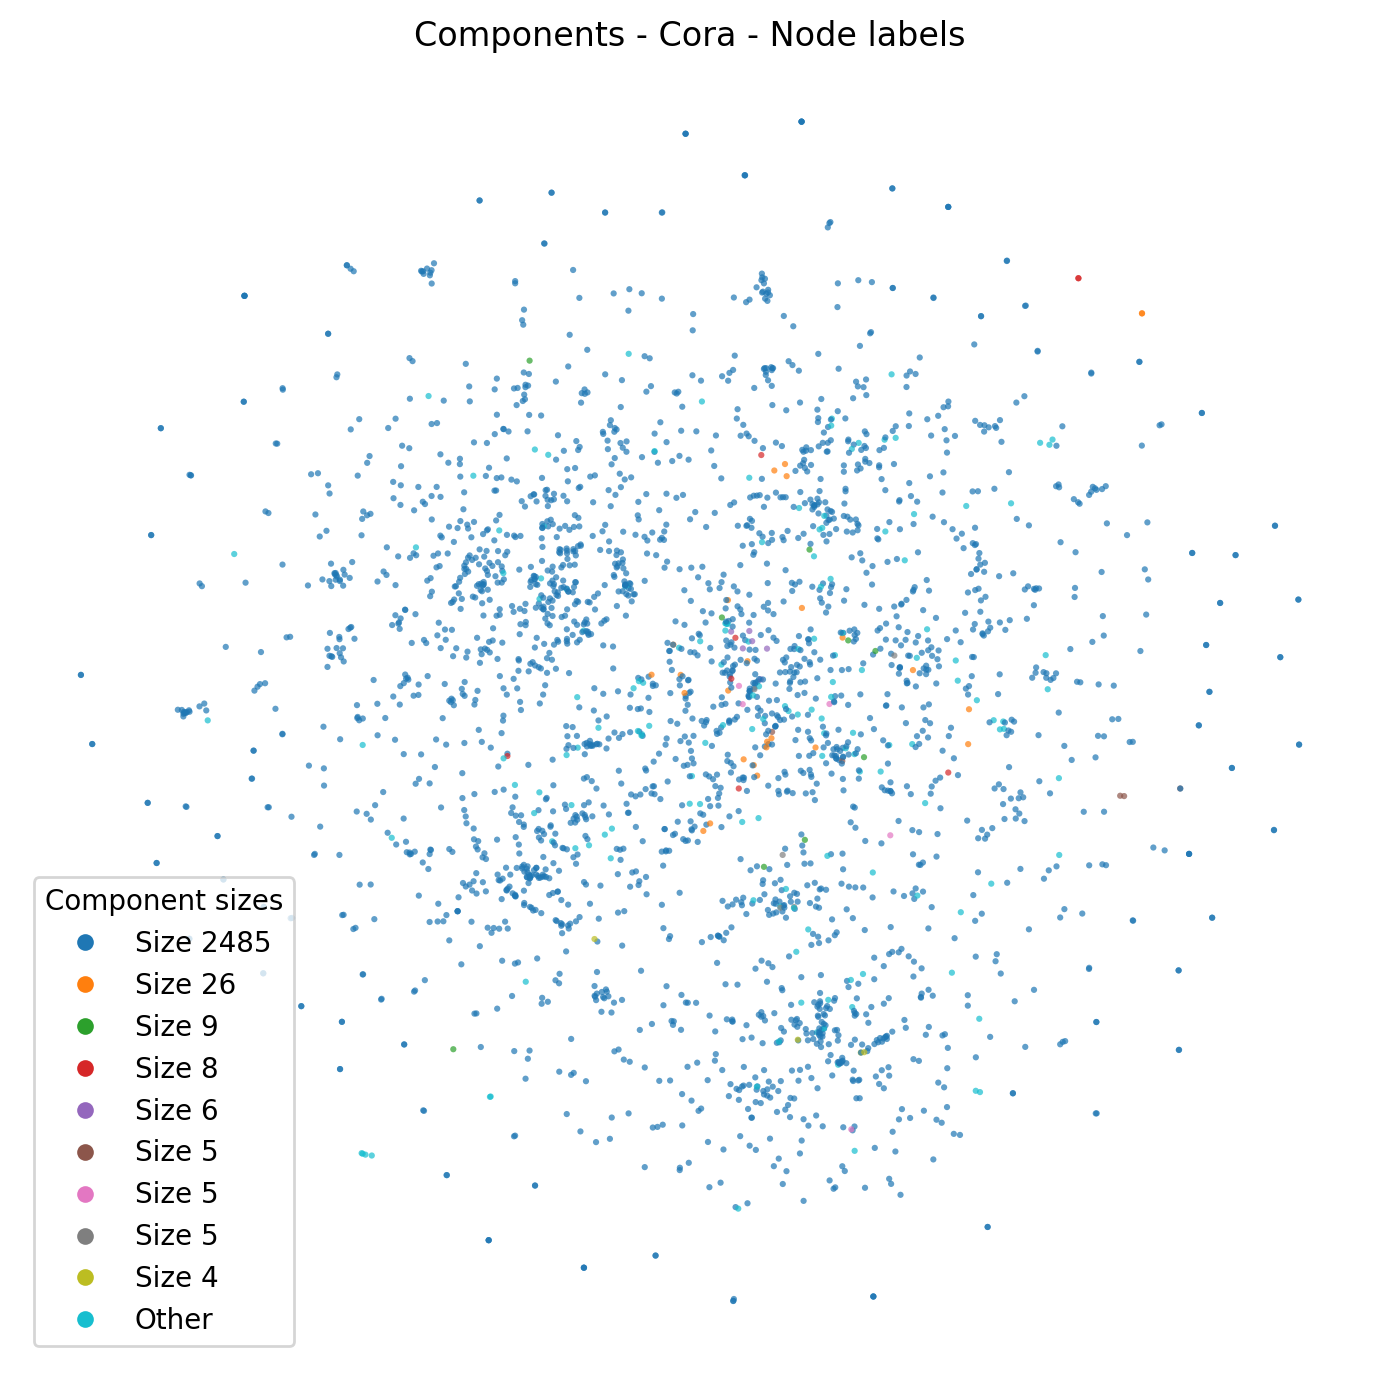

In [34]:
visualizer.plot_node_types()
visualizer.plot_node_degrees()
visualizer.plot_connected_components()